In [ ]:
import base64
from io import BytesIO
import time
import datetime
import os
import pprint
from IPython import display

import exifread

from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

import uuid
import os
import shutil
import uuid
import copy

import cognitive_face
from cognitive_face import face
from cognitive_face import vision
from cognitive_face import emotion
from cognitive_face import person_group

from urllib.parse import unquote, urlparse

## Initialize/Select Mongo collection

In [2]:
mongo_client = MongoClient()
def clean_db():
    for db in mongo_client.database_names():
        mongo_client.drop_database(db)
def new_result_collection_name():
    return time.strftime("%a-%b-%d-%H_%M_%S_%Y_result", time.strptime(time.ctime()))
def new_face_collection_name():
    return time.strftime("%a-%b-%d-%H_%M_%S_%Y_face", time.strptime(time.ctime()))
def new_vision_collection_name():
    return time.strftime("%a-%b-%d-%H_%M_%S_%Y_vision", time.strptime(time.ctime()))
# Select collection
#result_coll_time = 'Sat-Jun-25-12_07_44_2016_result'
#face_coll_time = 'Fri-Jul-01-13_54_44_2016_face'
#vision_coll_time = "Fri-Jul-01-13_54_44_2016_vision"
#result_coll_time = 'Fri-Jul-01-13_54_44_2016_result'


result_coll_time = new_result_collection_name()
face_coll_time = new_face_collection_name()
vision_coll_time = new_vision_collection_name()

db = mongo_client["test"]
result_coll = db[str(result_coll_time)]
face_coll = db[str(face_coll_time)]
vision_coll = db[str(vision_coll_time)]

print(face_coll_time)
print(result_coll_time)
print(vision_coll_time)

Sun-Sep-11-13_56_23_2016_face
Sun-Sep-11-13_56_23_2016_result
Sun-Sep-11-13_56_23_2016_vision


In [3]:
db = mongo_client["test"]
result_coll = db["YAT"]
ack = result_coll.insert_one({"testing":True})
ack.acknowledged
ack.inserted_id

ObjectId('5776c05b18b49329ada945cc')

## Add results to results collection mongodb

### Microsoft Cognitive Services Client

In [3]:
def init_ms():
    #_url = 'https://api.projectoxford.ai/face/v1.0/detect'
    face_key = 'd22370771840433ca59ead5bf43c03bc'
    vision_key = 'cdf4bd133a944c61abce00f352c41f4d'
    emotion_key = '99ed74aecea049d9ad2c3476756f8fcd'

    _maxNumRetries = 10
    global face_client, persongroup_client, vision_client, emotion_client
    face_client = Face(face_key)
    persongroup_client = PersonGroup(face_key)
    vision_client = Vision(vision_key)
    emotion_client = Emotion(emotion_key)

    # TODO Should not have my keys in this notebook, should do it this way
    # emotion_client = Emotion(os.environ['OXFORD_EMOTION_API_KEY'])
init_ms()

# Person Group

In [4]:

# Delete all person groups

for p in face_client.personGroup.list():
    face_client.personGroup.delete(p['personGroupId'])

# Create Persons

In [5]:
candidates =  {"hillary":{}, "trump":{}}#, 'bern':{}}

In [9]:
#Create Person Group¶

In [6]:
candidateGroupId = str(uuid.uuid4())
face_client.personGroup.create(candidateGroupId, 'candidate_group')
print(candidateGroupId)
face_client.personGroup.list()

93720071-f181-47fa-8fa4-7d67b05fc06f


[{'name': 'candidate_group',
  'personGroupId': '93720071-f181-47fa-8fa4-7d67b05fc06f',
  'userData': None}]

In [7]:
for candidate_name in candidates.keys():
    result = face_client.person.create(candidateGroupId, candidate_name)
    candidates[candidate_name]['personId'] = result['personId']
candidates

{'hillary': {'personId': '6852bc01-4658-4aba-889a-868659a2db78'},
 'trump': {'personId': '66806e3b-fa41-4477-8720-9dc16ce1f836'}}

### Populate Presidential Person Group¶

In [10]:
c = 0
for candidate_name in candidates.keys():
    candidate_path = "../images/candidates/"+candidate_name+"/cropped"
    candidate_images = [img_name for img_name in os.listdir(candidate_path)]
    for img_name in candidate_images:
        candidate_img_path = os.path.join(candidate_path, img_name)
        try:
            face_client.person.addFace(candidateGroupId, 
                                  candidates[candidate_name]['personId'] , 
                                  {'path': candidate_img_path})
            c+=1
            print(str(c), end="-")
        except Exception as e:
            print(candidate_name + " " + str(e))
            
print("Training with the following number of faces:")
for candidate_name in candidates.keys():
    print(candidate_name, len(face_client.person.list(candidateGroupId)[0]['persistedFaceIds']))

1-2-3-4-5-6-7-hillary status 400: {"error":{"code":"InvalidImage","message":"No face detected in the image."}}
8-hillary status 400: {"error":{"code":"InvalidImage","message":"No face detected in the image."}}
hillary status 400: {"error":{"code":"InvalidImage","message":"No face detected in the image."}}
9-10-hillary status 400: {"error":{"code":"InvalidImage","message":"No face detected in the image."}}
11-12-13-14-The oxford API was throttled. Retrying after 2 seconds
15-16-The oxford API was throttled. Retrying after 43 seconds
17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-trump status 400: {"error":{"code":"InvalidImage","message":"No face detected in the image."}}
35-The oxford API was throttled. Retrying after 44 seconds
36-37-38-39-trump status 400: {"error":{"code":"InvalidImage","message":"No face detected in the image."}}
40-41-trump status 400: {"error":{"code":"InvalidImage","message":"No face detected in the image."}}
42-43-44-45-46-47-48-trump status 400: {"error

### Train Presidential Person Group

In [11]:
for candidate_name in candidates.keys():
    status = face_client.personGroup.trainAndPollForCompletion(candidateGroupId)
    print(candidate_name)
    display.display(status)

hillary


{'createdDateTime': '9/11/2016 6:14:26 PM',
 'lastActionDateTime': '9/11/2016 6:14:28 PM',
 'message': None,
 'status': 'succeeded'}

trump


{'createdDateTime': '9/11/2016 6:14:28 PM',
 'lastActionDateTime': '9/11/2016 6:14:27 PM',
 'message': None,
 'status': 'succeeded'}

In [ ]:
# Test query code
#print(img_name)
i_name = os.path.join(downloaded_img_dir, img_name)
#i_name = ""
doc = result_coll.find_one({'img_name':i_name})
print(type(doc))
downloaded_images[0]
#os.path.join(downloaded_img_dir, img_name)


In [ ]:
# Reset dabase
mongo_client = MongoClient()
def clean_db():
    for db in mongo_client.database_names():
        mongo_client.drop_database(db)
def new_collection_name():
    return time.strftime("%a-%b-%d-%H_%M_%S_%Y", time.strptime(time.ctime()))
# Select collection
result_coll_time = 'Sat-Jun-25-12_07_44_2016_result'
result_coll_time = new_collection_name()
print(result_coll_time)
db = mongo_client["test"]
result_coll = db[str(result_coll_time)]

In [99]:
# How to insert a single result into database
add_ms_face_to_db(emotion_results, id_results, downloaded_img_dir, img_name, m_cloud_info)

{'candidates': [{'name': 'bern', 'personId': '5cd2972a-244b-4c40-913a-098b24cf462e', 'confidence': 0.68689}], 'faceId': '57bf37e3-938d-40fc-851a-82d581f019e9', 'faceRectangle': {'top': 52, 'left': 289, 'width': 66, 'height': 66}}
{'candidates': [{'name': 'hillary', 'personId': 'a68e5ed1-0759-4d6e-b8db-f0dd6f82d4c5', 'confidence': 0.69837}], 'faceId': '571dc892-8d07-4f61-a36c-65bb2584b637', 'faceRectangle': {'top': 96, 'left': 156, 'width': 64, 'height': 64}}


### Add ms_face to face collection mongodb

In [13]:
def add_ms_face_to_db(emotion_results, id_results, 
                      downloaded_img_dir, img_name, m_cloud_info):

    for emotion_result, id_result in zip(emotion_results, id_results):
        downloaded_img_path = os.path.join(downloaded_img_dir, img_name)
        im = Image.open(downloaded_img_path)
        l = emotion_result['faceRectangle']['left']
        t = emotion_result['faceRectangle']['top']
        w = emotion_result['faceRectangle']['width']
        h = emotion_result['faceRectangle']['height']
        im_face = im.crop((l,t,w+l,h+t))
        buffer = BytesIO()
        im_face.save(buffer, format="JPEG")
        face_base64 = str(base64.b64encode(buffer.getvalue()))[2:-1]
        face_img_base64 = "data:image/jpeg;base64,"+ face_base64

        if 'candidates' in id_result.keys() and len(id_result['candidates']) > 0:
            name =  id_result['candidates'][0]['name']
            person_id =  id_result['candidates'][0]['name']
        else:
            name = None
            person_id = None
            
        ms_face = {
        'mediacloud_stories_id':m_cloud_info.mediacloud_stories_id.values.tolist()[0],
        'face_thumbnail': face_img_base64,
        'personId': person_id ,
        'confidence': [ candidate['confidence'] for candidate in id_results[0]['candidates']],
        'name': name,
        'height': emotion_result['faceRectangle']['height'],
        'left': emotion_result['faceRectangle']['left'],
        'top': emotion_result['faceRectangle']['top'],
        'width': emotion_result['faceRectangle']['width'],
        'anger': emotion_result['scores']['anger'],
        'contempt': emotion_result['scores']['contempt'],
        'disgust': emotion_result['scores']['disgust'],
        'fear': emotion_result['scores']['fear'],
        'happiness': emotion_result['scores']['happiness'],
        'neutral': emotion_result['scores']['neutral'],
        'sadness': emotion_result['scores']['sadness'],
        'surprise': emotion_result['scores']['surprise'] }
        face_ack = db[str(face_coll_time)].insert_one(ms_face)

### Add ms_vision to vision collection mongodb

In [14]:
def add_ms_vision_to_db(vision_result, downloaded_img_dir, img_name, m_cloud_info):

    downloaded_img_path = os.path.join(downloaded_img_dir, img_name)
    im = Image.open(downloaded_img_path)
    buffer = BytesIO()
    im.save(buffer, format="JPEG")
    im_base64 = str(base64.b64encode(buffer.getvalue()))[2:-1]
    img_base64 = "data:image/jpeg;base64,"+ im_base64

    ms_vision = {
    'mediacloud_stories_id':m_cloud_info.mediacloud_stories_id.values.tolist()[0],
    'vision_thumbnail': img_base64,
    'categories': vision_result.get('categories', []),
    'color': vision_result['color'],
    'faces': vision_result['faces'],
    'imageType': vision_result['imageType'],
    'metadata': vision_result['metadata']
    }
    vision_ack = db[str(vision_coll_time)].insert_one(ms_vision)
    return vision_ack

In [20]:
vision_results
"""
{'categories': [{'name': 'people_crowd', 'score': 0.4609375},
  {'name': 'people_group', 'score': 0.1875}],
 'color': {'accentColor': 'AE1D60',
  'dominantColorBackground': 'Grey',
  'dominantColorForeground': 'Black',
  'dominantColors': ['Black', 'Grey'],
  'isBWImg': False},
 'faces': [{'age': 66,
   'faceRectangle': {'height': 69, 'left': 133, 'top': 86, 'width': 69},
   'gender': 'Female'}],
 'imageType': {'clipArtType': 0, 'lineDrawingType': 0},
 'metadata': {'format': 'Jpeg', 'height': 399, 'width': 592},
 'requestId': '4ce768cb-2ce1-4014-9f64-77da1cbe2f96'}
""";

### Add result to ms_result collection mongodb

In [15]:
def add_ms_result_to_db(vision_results, face_results, emotion_results, id_results, 
                        downloaded_img_dir, img_name, face_img_name, m_cloud_info):
    downloaded_img_path = os.path.join(downloaded_img_dir, img_name)
    im = Image.open(downloaded_img_path)
    buffer = BytesIO()
    im.save(buffer, format="JPEG")
    img_base64 = str(base64.b64encode(buffer.getvalue()))[2:-1]
    original_img_base64 = "data:image/jpeg;base64,"+ img_base64

    im_exif = open(downloaded_img_path, 'rb')    
    exif = exifread.process_file(im_exif)
    
    if face_img_name:
        im_face = Image.open(face_img_name)
        buffer = BytesIO()
        im_face.save(buffer, format="JPEG")
        face_base64 = str(base64.b64encode(buffer.getvalue()))[2:-1]
        face_img_base64 = "data:image/jpeg;base64,"+ face_base64
        
        size = 128, 128
        im_face.thumbnail(size, Image.ANTIALIAS)
        buffer = BytesIO()
        im_face.save(buffer, format="JPEG")
        thumb_face_base64 = str(base64.b64encode(buffer.getvalue()))[2:-1]
        thumb_img_base64 = "data:image/jpeg;base64," + thumb_face_base64
    else:
        face_img_base64 = None
        
        size = 128, 128
        im.thumbnail(size, Image.ANTIALIAS)
        buffer = BytesIO()
        im.save(buffer, format="JPEG")
        thumb_face_base64 = str(base64.b64encode(buffer.getvalue()))[2:-1]
        thumb_img_base64 = "data:image/jpeg;base64," + thumb_face_base64
    
    parsed_uri =urlparse(unquote(img_name))
    domain = parsed_uri.netloc.split('.')[1]
    
    ms_result = {
    "exif": exif,
    "domain" :  domain,
    "ms_thumbnail": thumb_img_base64,
    "downloaded_img_dir": downloaded_img_dir,
    "img_name": img_name,
    "original_photo_path": "/user/resonon/tutorial/images/cl_low",
    "face_detected_photo_path": "/user/resonon/tutorial/images/detected_faces",
    "face_result": face_results,
    "vision_result": vision_results,
    "emotion_result": emotion_results,
    "id_result": id_results,
    "m_cloud_info" : m_cloud_info.to_json()
    #"photo":  original_img_base64,
    #"face": face_img_base64,
    }
    result_ack = db[str(result_coll_time)].insert_one(ms_result)
    return result_ack

In [16]:
r_db = db[str(result_coll_time)]
cursor =  r_db.find()
cursor.count()

0

### Analyze and Detect Faces in Image with Microsoft Cognitive Services¶


In [17]:
detect_options = {'returnFaceLandmarks': True,
    'returnFaceAttributes': 'age,gender,headPose,smile,facialHair'}

analyze_options = {'ImageType': True,
    'Color': True,
    'Faces': True,
    'Categories': True,
    'Celebrity': True}

emotions_options = {'faceRectangles': ''}

In [27]:
processed_img_dir = "../images/processed/"
downloaded_img_dir = "../images/low_cl_selected/"
ms_face_img_dir = "../images/faces_ms_photo_img/" 
downloaded_images = [img_name for img_name in os.listdir(downloaded_img_dir)]
downloaded_images_mongo_id = []

In [11]:
def draw_faces(face_results, img_name, fig2, ax2):
    for face in face_results:
        # draw square around faces
        r = face['faceRectangle']
        p = patches.Rectangle(
            (r['left'], r['top']), r['width'], r['height'], 
            color="#00FF00", fill=False, linewidth=5 )
        ax2.add_patch(p)
        face_ids.append(face['faceId'])

    ms_face_img_path = os.path.join(ms_face_img_dir, img_name)
    fig2.savefig(ms_face_img_path, format="jpeg", bbox_inches='tight')
    return ms_face_img_path

def add_name_faceRectangle_id_result(id_results, face_results):
    for id_result in id_results:
        for candidate in id_result['candidates']:
            personData = face_client.person.get(candidateGroupId, candidate['personId'])
            candidate["name"] = personData['name']  
        for face_result in face_results:
            if id_result['faceId'] == face_result['faceId']:                
                id_result['faceRectangle'] = face_result['faceRectangle']              

In [100]:
#clean_db()
#if id_results and id_results.has
id_candidates = [ id_result['candidates'] for id_result in id_results]
names =  [candidate.get('name',"") for candidate in id_candidates[0]]


In [127]:
id_results
title_candidates
#title_names
#[item for item in id_candidates]
[candidate[0].get('name',"") for candidate in title_candidates if candidate]

['hillary']

Mon Jul  4 15:10:24 2016
1 Face:  2


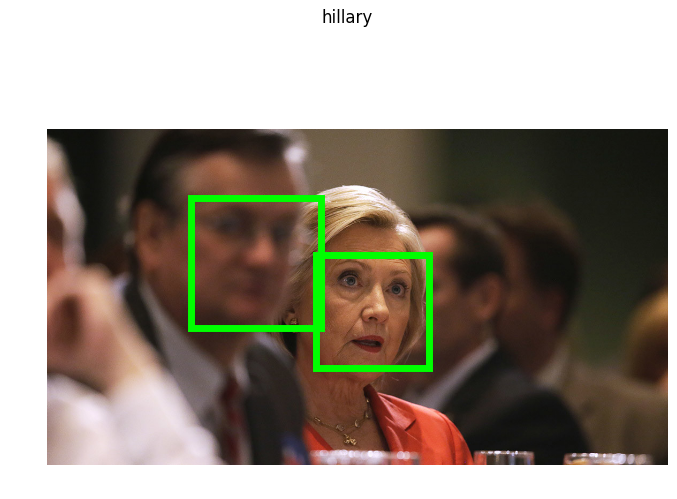

In [128]:
%matplotlib nbagg
print(time.asctime())
c = 0
c_max = 1
c_min = 0
compute_vision = False
plt.ioff()

# Load media cloud info
m_cloud_df = pd.read_csv('image_urls.csv')

for img_name in downloaded_images[73:74]:
    c+=1
    m_cloud_info = m_cloud_df.loc[m_cloud_df['image_url'] ==  unquote(img_name)]
    if m_cloud_info.empty:
        print(str(c)+" m_could_info empty")
        continue
    downloaded_img_path = os.path.join(downloaded_img_dir, img_name)

    if  result_coll.find_one({'img_name':img_name}):
        print(str(c)+" skipping")
        continue
    #if c < c_min:
    #    print(str(c)+" passing")
    #    continue
    im = Image.open(downloaded_img_path)

    detect_options_copy = copy.copy(detect_options)    
    detect_options_copy['path'] = downloaded_img_path
    face_results = face_client.detect(detect_options_copy)

    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_axis_off()
    ax2.imshow(im);

    if len(face_results) != 0:
        print(str(c) + " Face:  " + str(len(face_results))) # + img_name )
        face_ids = []
        ms_face_img_path = draw_faces(face_results, img_name, fig2, ax2)

        # face_ids may support than 7, research is needed.
        face_ids = face_ids[:7]  # Slicing face_ids to 7 in order to avoid  Exception: status 400: {"error":{"code":"BadArgument","message":"The length of faceIds is not in a valid range."}}  
        id_results = face_client.identify(candidateGroupId, face_ids)
        add_name_faceRectangle_id_result(id_results, face_results)

        emotions_options_copy = copy.copy(emotions_options)
        emotions_options_copy['path'] = downloaded_img_path
        emotion_results = emotion_client.recognize(emotions_options_copy)

        add_ms_face_to_db(emotion_results, id_results, downloaded_img_dir, img_name, m_cloud_info)
        title_candidates = [ id_result['candidates'] for id_result in id_results]
        title_names =  [candidate[0].get('name',"") for candidate in title_candidates if candidate]
        fig2.suptitle(" ".join(title_names))
        mongo_id = add_ms_result_to_db(vision_results, face_results, emotion_results, id_results, 
                                     downloaded_img_dir, img_name, ms_face_img_path, m_cloud_info)
    else:
        print(str(c) + " ***No Face*** ") # + " " + img_name)
        noface_rec_path = os.path.join(ms_face_img_dir, "no_face_" + img_name)
        shutil.copyfile(downloaded_img_path, noface_rec_path)

    if not compute_vision:
        vision_results = {}
        mongo_id = add_ms_result_to_db(vision_results, face_results, None, None, 
                                     downloaded_img_dir, img_name, None, m_cloud_info)

    if mongo_id.acknowledged:
        downloaded_images_mongo_id.append((img_name, mongo_id.inserted_id))

    if compute_vision:
        print("computing")
        analyze_options_copy = copy.copy(analyze_options)
        analyze_options_copy['path'] = downloaded_img_path
        vision_result = vision_client.analyze(analyze_options_copy)
        add_ms_vision_to_db(vision_result, downloaded_img_dir, img_name, m_cloud_info)
        if 'categories' in vision_result:
            print("titles")
            fig2.axes[0].set_title(str(vision_result['categories'][0]))

    #if 'categories' in vision_results:
    #    fig2.axes[0].set_title(str(vision_results['categories'][0]))
    fig2.patch.set_facecolor('#d3d3d3')
    display.display(fig2)
    fig2.savefig(os.path.join(processed_img_dir, img_name), format='jpg')
    #if c >= 10 :
    #    break 
    

In [170]:
#m_cloud_info = m_cloud_df.loc[m_cloud_df['image_url'].str.contains(unquote(img_name))]
#m_cloud_info
#len(unquote(img_name))
#s = m_cloud_df['image_url']
#(s.isnull().sum(), len(s))
len(m_cloud_info)
len(downloaded_images)

116

In [89]:
id_results

[{'candidates': [{'confidence': 0.68689,
    'name': 'bern',
    'personId': '5cd2972a-244b-4c40-913a-098b24cf462e'}],
  'faceId': '57bf37e3-938d-40fc-851a-82d581f019e9',
  'faceRectangle': {'height': 66, 'left': 289, 'top': 52, 'width': 66}},
 {'candidates': [{'confidence': 0.69837,
    'name': 'hillary',
    'personId': 'a68e5ed1-0759-4d6e-b8db-f0dd6f82d4c5'}],
  'faceId': '571dc892-8d07-4f61-a36c-65bb2584b637',
  'faceRectangle': {'height': 64, 'left': 156, 'top': 96, 'width': 64}}]

In [124]:
emotion_results

[{'faceRectangle': {'height': 85, 'left': 89, 'top': 131, 'width': 85},
  'scores': {'anger': 7.13784454e-09,
   'contempt': 1.49778956e-09,
   'disgust': 5.97165837e-08,
   'fear': 1.14111871e-11,
   'happiness': 0.9999995,
   'neutral': 3.853198e-07,
   'sadness': 5.045588e-08,
   'surprise': 7.518327e-10}},
 {'faceRectangle': {'height': 67, 'left': 445, 'top': 151, 'width': 67},
  'scores': {'anger': 2.251298e-07,
   'contempt': 3.82966853e-10,
   'disgust': 1.2570199e-06,
   'fear': 1.42734468e-12,
   'happiness': 0.99999845,
   'neutral': 1.10150973e-08,
   'sadness': 4.61393661e-08,
   'surprise': 6.28956e-10}}]

In [125]:
face_results

[{'faceAttributes': {'age': 60.0,
   'facialHair': {'beard': 0.2, 'moustache': 0.0, 'sideburns': 0.0},
   'gender': 'male',
   'headPose': {'pitch': 0.0, 'roll': 4.8, 'yaw': 22.8},
   'smile': 0.152},
  'faceId': '788a1a4d-743e-43c9-901d-57ff3be43207',
  'faceLandmarks': {'eyeLeftBottom': {'x': 113.7, 'y': 155.5},
   'eyeLeftInner': {'x': 119.7, 'y': 154.5},
   'eyeLeftOuter': {'x': 107.8, 'y': 153.6},
   'eyeLeftTop': {'x': 114.4, 'y': 151.7},
   'eyeRightBottom': {'x': 151.0, 'y': 161.2},
   'eyeRightInner': {'x': 146.2, 'y': 158.8},
   'eyeRightOuter': {'x': 155.9, 'y': 160.3},
   'eyeRightTop': {'x': 151.8, 'y': 156.5},
   'eyebrowLeftInner': {'x': 128.7, 'y': 147.6},
   'eyebrowLeftOuter': {'x': 98.9, 'y': 147.7},
   'eyebrowRightInner': {'x': 141.2, 'y': 150.2},
   'eyebrowRightOuter': {'x': 161.9, 'y': 154.4},
   'mouthLeft': {'x': 106.0, 'y': 189.3},
   'mouthRight': {'x': 145.6, 'y': 194.7},
   'noseLeftAlarOutTip': {'x': 122.3, 'y': 173.9},
   'noseLeftAlarTop': {'x': 128.6, 

In [34]:
vision_result

{'categories': [{'name': 'others_', 'score': 0.00390625},
  {'name': 'text_menu', 'score': 0.20703125}],
 'color': {'accentColor': 'AE891D',
  'dominantColorBackground': 'Black',
  'dominantColorForeground': 'Yellow',
  'dominantColors': ['Yellow'],
  'isBWImg': False},
 'faces': [],
 'imageType': {'clipArtType': 0, 'lineDrawingType': 0},
 'metadata': {'format': 'Jpeg', 'height': 187, 'width': 280},
 'requestId': 'dd5c6016-01d2-4738-bb6f-a3dbdb3af9de'}

In [11]:
# Variables

_url = 'https://api.projectoxford.ai/face/v1.0/detect'
_key = 'd22370771840433ca59ead5bf43c03bc'
_maxNumRetries = 10

../images/low_cl_selected/http%3A%2F%2Fstatic01.nyt.com%2Fimages%2F2016%2F01%2F25%2Fopinion%2F25axelrodWeb%2F25axelrodWeb-master675.jpg


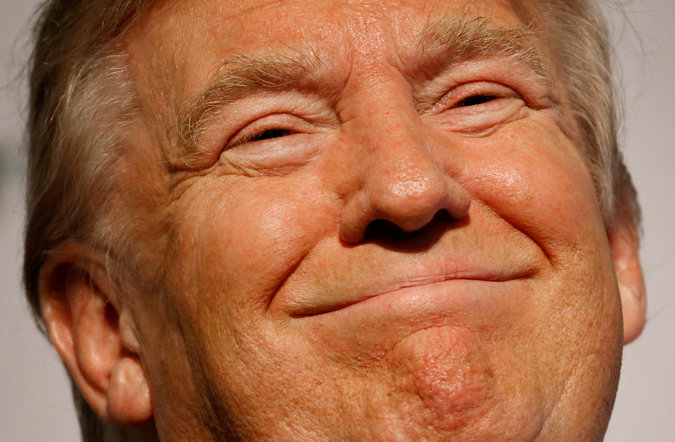

In [113]:
for img_name in [downloaded_images[59]]:
    print(os.path.join(downloaded_img_dir, img_name))
    display.display(display.Image(os.path.join(downloaded_img_dir, img_name)), format='jpg')

In [ ]:
def test():
    

In [100]:
len(downloaded_images)

116

In [129]:
plt.close('all')